## Sentiment Analysis

In [1]:
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

--2024-01-08 17:42:48--  https://lazyprogrammer.me/course_files/AirlineTweets.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/csv]
Saving to: ‘AirlineTweets.csv’

AirlineTweets.csv   100%[===================>]   3.26M  3.38MB/s    in 1.0s    

2024-01-08 17:42:50 (3.38 MB/s) - ‘AirlineTweets.csv’ saved [3421431/3421431]



In [4]:
from transformers import pipeline
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [8]:
mps_device = "mps"
# pipe = pipeline('zero-shot-classification', device = mps_device)
classifier = pipeline("sentiment-analysis", device = mps_device)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [9]:
type(classifier)

transformers.pipelines.text_classification.TextClassificationPipeline

In [12]:
classifier("This is such a great movie")

[{'label': 'POSITIVE', 'score': 0.9998791217803955}]

In [13]:
classifier("The movie had it's ups and downs, overall i liked it")

[{'label': 'POSITIVE', 'score': 0.9997003078460693}]

In [14]:
classifier("I'm not sure if i liked the movie or not")

[{'label': 'NEGATIVE', 'score': 0.9994564652442932}]

In [ ]:
classifier("it's a one time watch")

In [ ]:
classifier(["the taste of the dish is blank",
            "Though the taste of the dish was blank, i liked it. i must be crazy or i should see a shrink"])

In [ ]:
import torch
torch.cuda.is_available()

In [ ]:
torch.cuda.current_device()

In [15]:
# classifier = pipeline("sentiment-analysis",device=0)
df_ = pd.read_csv("AirlineTweets.csv")

In [16]:
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [17]:
df = df_[["text", "airline_sentiment"]]

<Axes: >

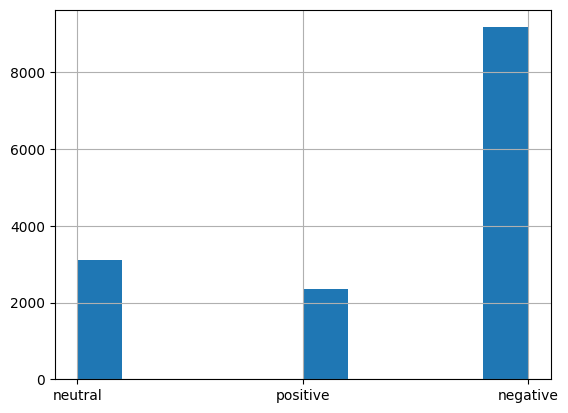

In [18]:
df["airline_sentiment"].hist()

In [19]:
df = df[df.airline_sentiment != 'neutral']

In [20]:
target_map = {'positive':1, 'negative':0}
df['target'] = df['airline_sentiment'].map(target_map)

In [21]:
df.head()

,text,airline_sentiment,target
1,@VirginAmerica plus you've added commercials t...,positive,1
3,@VirginAmerica it's really aggressive to blast...,negative,0
4,@VirginAmerica and it's a really big bad thing...,negative,0
5,@VirginAmerica seriously would pay $30 a fligh...,negative,0
6,"@VirginAmerica yes, nearly every time I fly VX...",positive,1


In [22]:
len(df)

11541

In [23]:
texts = df['text'].tolist()

In [24]:
predictions = classifier(texts)

In [25]:
predictions[:5]

[{'label': 'POSITIVE', 'score': 0.6070849895477295},
 {'label': 'NEGATIVE', 'score': 0.9973449110984802},
 {'label': 'NEGATIVE', 'score': 0.9995823502540588},
 {'label': 'NEGATIVE', 'score': 0.9854249358177185},
 {'label': 'POSITIVE', 'score': 0.9553214311599731}]

In [ ]:
probs = [d['score'] if d['label'].startswith('P') else 1 - d['score'] for d in predictions]


In [ ]:
probs[:5]

In [ ]:
preds = [1 if d['label'].startswith('P') else 0 for d in predictions]
preds[:5]

In [ ]:
preds = np.array(preds)

In [ ]:
print("acc:", np.mean(df['target']==preds))

In [ ]:
cm = confusion_matrix(df['target'], preds, normalize='true')

In [ ]:
cm

In [ ]:
def plot_cm(cm):
    classes = ['negative', 'positive']
    df_cm = pd.DataFrame(cm, index=classes,columns=classes)
    ax = sn.heatmap(df_cm, annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")

plot_cm(cm)

In [ ]:
f1_score(df['target'], preds )

f1 score depends on what we are trying to predict. it really depends on which label we have assigned as zero and which label as 1. below demonstrates that

In [ ]:
f1_score(1-df['target'], 1-preds)

roc_auc is not sensitive to the labels

In [ ]:
roc_auc_score(df['target'], probs)


In [ ]:
roc_auc_score(1- df['target'], 1- np.array(probs))

## Text Generation

In [ ]:
!wget -nc https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/hmm_class/robert_frost.txt

In [ ]:
from transformers import pipeline, set_seed
import textwrap
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

In [ ]:
# !cat robert_frost.txt

In [ ]:
lines = [line.rstrip() for line in open('robert_frost.txt')]
lines = [line for line in lines if len(line)>0]

In [ ]:
gen = pipeline("text-generation")

In [ ]:
set_seed(1234)

In [ ]:
lines[0]

In [ ]:
gen(lines[0])

In [ ]:
pprint(_)

In [ ]:
_

In [ ]:
pprint(gen(lines[0], max_length=20))

In [ ]:
pprint(gen(lines[0], num_return_sequences=3, max_length=20))

In [ ]:
import textwrap

text = "This is a long piece of text that we want to wrap to a specific width using textwrap."

wrapped_text = textwrap.fill(text, width=30)
print(wrapped_text)


In [ ]:
def wrap(x):
    return textwrap.fill(x, replace_whitespace=True, fix_sentence_endings=True)

print(wrap("This is a long piece of text that we want to wrap to a specific width using textwrap."))

In [ ]:
out = gen("who let the dogs out", max_length = 30)
wrap(out[0]['generated_text'])

## Masked Language Model

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv

--2024-01-07 05:05:15--  https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5085081 (4.8M) [text/csv]
Saving to: ‘bbc_text_cls.csv’

bbc_text_cls.csv    100%[===================>]   4.85M  22.3MB/s    in 0.2s    

2024-01-07 05:05:15 (22.3 MB/s) - ‘bbc_text_cls.csv’ saved [5085081/5085081]



In [ ]:
import numpy as np
import pandas as pd
import textwrap
from pprint import pprint

from transformers import pipeline

In [ ]:
df = pd.read_csv('bbc_text_cls.csv')

In [ ]:
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [ ]:
import numpy as np
import pandas as pd
import textwrap
from pprint import pprint
from transformers import pipeline


In [ ]:
df = pd.read_csv('bbc_text_cls.csv')
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [ ]:
labels = set(df['labels'])
labels

{'business', 'entertainment', 'politics', 'sport', 'tech'}

In [ ]:
label = 'business'
df = df[df['labels']== label]

In [ ]:
texts = df['text']
texts.head()

0    Ad sales boost Time Warner profit\n\nQuarterly...
1    Dollar gains on Greenspan speech\n\nThe dollar...
2    Yukos unit buyer faces loan claim\n\nThe owner...
3    High fuel prices hit BA's profits\n\nBritish A...
4    Pernod takeover talk lifts Domecq\n\nShares in...
Name: text, dtype: object

In [ ]:
i = np.random.choice(texts.shape[0])

In [ ]:
doc = texts.iloc[i]
print(textwrap.fill(doc, replace_whitespace=False, fix_sentence_endings=True))

Takeover rumour lifts Exel shares

Shares in storage and delivery firm
Exel closed up 9% at a two-and-a-half year high on Tuesday on
speculation it is to receive an imminent takeover bid.

The talk in
the City is that US giant United Parcel Services (UPS) is the most
likely bidder for the firm.  Yet other names mentioned in connection
to buying Exel are DHL-owner Deutsche Post and finance firm GE
Capital.  With its shares closing Tuesday at 873p, Bracknell-based
Exel is currently valued at £2.6bn ($6.3bn).

Exel employs 109,000
people in more than 120 countries and has itself been active in the
consolidation of the logistics sector, paying £328m to buy fellow UK
firm Tibbett & Britten last August.  Its customers include Boots,
Burberry, Mothercare and consumer products giant Procter & Gamble.
Andrew Beh, of brokers ING, said UPS and Deutsche Post were the most
likely bidders and an offer of 950p a share would be fair if a bidding
battle did not break out.  "It's a great strategic fit f

In [ ]:
mlm = pipeline('fill-mask')

No model was supplied, defaulted to distilroberta-base and revision ec58a5b (https://huggingface.co/distilroberta-base).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
mlm('Bombardier chief to leave <mask>')

[{'score': 0.06950785219669342,
  'token': 633,
  'token_str': ' job',
  'sequence': 'Bombardier chief to leave job'},
 {'score': 0.0669308453798294,
  'token': 1470,
  'token_str': ' France',
  'sequence': 'Bombardier chief to leave France'},
 {'score': 0.05273520573973656,
  'token': 558,
  'token_str': ' office',
  'sequence': 'Bombardier chief to leave office'},
 {'score': 0.025823047384619713,
  'token': 2201,
  'token_str': ' Paris',
  'sequence': 'Bombardier chief to leave Paris'},
 {'score': 0.021368566900491714,
  'token': 896,
  'token_str': ' Canada',
  'sequence': 'Bombardier chief to leave Canada'}]

In [ ]:
text = 'Shares in <mask> and plane-making ' + \
  'giant Bombardier have fallen to a 10-year low following the departure ' + \
  'of its chief executive and two members of the board.'

mlm(text)

[{'score': 0.6640956401824951,
  'token': 11016,
  'token_str': ' Airbus',
  'sequence': 'Shares in Airbus and plane-making giant Bombardier have fallen to a 10-year low following the departure of its chief executive and two members of the board.'},
 {'score': 0.2614656686782837,
  'token': 6722,
  'token_str': ' Boeing',
  'sequence': 'Shares in Boeing and plane-making giant Bombardier have fallen to a 10-year low following the departure of its chief executive and two members of the board.'},
 {'score': 0.023635322228074074,
  'token': 15064,
  'token_str': ' aerospace',
  'sequence': 'Shares in aerospace and plane-making giant Bombardier have fallen to a 10-year low following the departure of its chief executive and two members of the board.'},
 {'score': 0.01458178460597992,
  'token': 8537,
  'token_str': ' airlines',
  'sequence': 'Shares in airlines and plane-making giant Bombardier have fallen to a 10-year low following the departure of its chief executive and two members of the

In [ ]:
text = 'Shares in train and plane-making ' + \
  'giant Bombardier have fallen to a 10-year low following the departure ' + \
  'of its chief <mask> and two members of the board.'

pprint(mlm(text))

[{'score': 0.9897111058235168,
  'sequence': 'Shares in train and plane-making giant Bombardier have fallen '
              'to a 10-year low following the departure of its chief executive '
              'and two members of the board.',
  'token': 1031,
  'token_str': ' executive'},
 {'score': 0.006391047965735197,
  'sequence': 'Shares in train and plane-making giant Bombardier have fallen '
              'to a 10-year low following the departure of its chief '
              'executives and two members of the board.',
  'token': 4585,
  'token_str': ' executives'},
 {'score': 0.0016239372780546546,
  'sequence': 'Shares in train and plane-making giant Bombardier have fallen '
              'to a 10-year low following the departure of its chief economist '
              'and two members of the board.',
  'token': 7473,
  'token_str': ' economist'},
 {'score': 0.0007142710965126753,
  'sequence': 'Shares in train and plane-making giant Bombardier have fallen '
              'to a 10-ye

In [2]:
from transformers import pipeline

In [3]:
ner = pipeline("ner", aggregation_strategy='simple', device=0)

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

In [5]:
import pickle
!wget -nc https://lazyprogrammer.me/course_files/nlp/ner_train.pkl
!wget -nc https://lazyprogrammer.me/course_files/nlp/ner_test.pkl

File ‘ner_train.pkl’ already there; not retrieving.

File ‘ner_test.pkl’ already there; not retrieving.



In [6]:
with open('ner_train.pkl', 'rb') as f:
  corpus_train = pickle.load(f)

with open('ner_test.pkl', 'rb') as f:
  corpus_test = pickle.load(f)

In [7]:
inputs = []
targets = []

for sentence_tag_pairs in corpus_test:
  tokens = []
  target = []
  for token, tag in sentence_tag_pairs:
    tokens.append(token)
    target.append(tag)
  inputs.append(tokens)
  targets.append(target)

In [9]:
for k,i in zip(inputs[9], targets[9]):
    print(k,i)


He O
was O
well O
backed O
by O
England B-LOC
hopeful O
Mark B-PER
Butcher I-PER
who O
made O
70 O
as O
Surrey B-ORG
closed O
on O
429 O
for O
seven O
, O
a O
lead O
of O
234 O
. O


In [10]:
from nltk.tokenize.treebank import TreebankWordDetokenizer
detokenizer = TreebankWordDetokenizer()

In [11]:
detokenizer.detokenize(inputs[9])

'He was well backed by England hopeful Mark Butcher who made 70 as Surrey closed on 429 for seven, a lead of 234.'

In [12]:
ner(detokenizer.detokenize(inputs[9]))

[{'entity_group': 'LOC',
  'score': 0.99967515,
  'word': 'England',
  'start': 22,
  'end': 29},
 {'entity_group': 'PER',
  'score': 0.99974275,
  'word': 'Mark Butcher',
  'start': 38,
  'end': 50},
 {'entity_group': 'ORG',
  'score': 0.9996264,
  'word': 'Surrey',
  'start': 66,
  'end': 72}]

Since our target and inputs are in a particular format in input dataset, we need to convert it to the same format using below function

In [14]:
def compute_prediction(tokens, input_, ner_result):
  # map hugging face ner result to list of tags for later performance assessment
  # tokens is the original tokenized sentence
  # input_ is the detokenized string

  predicted_tags = []
  state = 'O' # keep track of state, so if O --> B, if B --> I, if I --> I
  current_index = 0
  for token in tokens:
    # find the token in the input_ (should be at or near the start)
    index = input_.find(token)
    assert(index >= 0)
    current_index += index # where we are currently pointing to

    # print(token, current_index) # debug

    # check if this index belongs to an entity and assign label
    tag = 'O'
    for entity in ner_result:
      if current_index >= entity['start'] and current_index < entity['end']:
        # then this token belongs to an entity
        if state == 'O':
          state = 'B'
        else:
          state = 'I'
        tag = f"{state}-{entity['entity_group']}"
        break
    if tag == 'O':
      # reset the state
      state = 'O'
    predicted_tags.append(tag)

    # remove the token from input_
    input_ = input_[index + len(token):]

    # update current_index
    current_index += len(token)

  # sanity check
  # print("len(predicted_tags)", len(predicted_tags))
  # print("len(tokens)", len(tokens))
  assert(len(predicted_tags) == len(tokens))
  return predicted_tags

In [15]:
input_ = detokenizer.detokenize(inputs[9])
ner_result = ner(input_)
ptags = compute_prediction(inputs[9], input_, ner_result)

In [17]:
input_.find('well')

7

In [18]:
for k,i,j in zip(inputs[9], targets[9], ptags):
    print(k,i,j)

He O O
was O O
well O O
backed O O
by O O
England B-LOC B-LOC
hopeful O O
Mark B-PER B-PER
Butcher I-PER I-PER
who O O
made O O
70 O O
as O O
Surrey B-ORG B-ORG
closed O O
on O O
429 O O
for O O
seven O O
, O O
a O O
lead O O
of O O
234 O O
. O O


In [19]:
from sklearn.metrics import accuracy_score, f1_score
accuracy_score(targets[9], ptags)

1.0

In [20]:
detok_inputs = []
for tokens in inputs:
    text = detokenizer.detokenize(tokens)
    detok_inputs.append(text)

ner_results = ner(detok_inputs)

In [21]:
predictions = []
for tokens, text, ner_result in zip(inputs, detok_inputs, ner_results):
  pred = compute_prediction(tokens, text, ner_result)
  predictions.append(pred)

In [25]:
predictions[:1]

[['O', 'O', 'B-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']]

In [26]:
targets[:1]

[['O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']]

In [27]:
def flatten(list_of_lists):
  flattened = [val for sublist in list_of_lists for val in sublist]
  return flattened

In [28]:
flat_predictions = flatten(predictions)
flat_targets = flatten(targets)

In [29]:
from sklearn.metrics import accuracy_score
accuracy_score(flat_predictions,flat_targets)

0.9916563354782848

## Text Summarization

In [30]:
!wget -nc https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv

--2024-01-08 06:20:34--  https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5085081 (4.8M) [text/csv]
Saving to: ‘bbc_text_cls.csv’

bbc_text_cls.csv    100%[===================>]   4.85M  --.-KB/s    in 0.07s   

2024-01-08 06:20:34 (66.2 MB/s) - ‘bbc_text_cls.csv’ saved [5085081/5085081]



In [31]:
import pandas as pd
import numpy as np
import textwrap
from transformers import pipeline

In [32]:
df = pd.read_csv('bbc_text_cls.csv')

In [33]:
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


<Axes: >

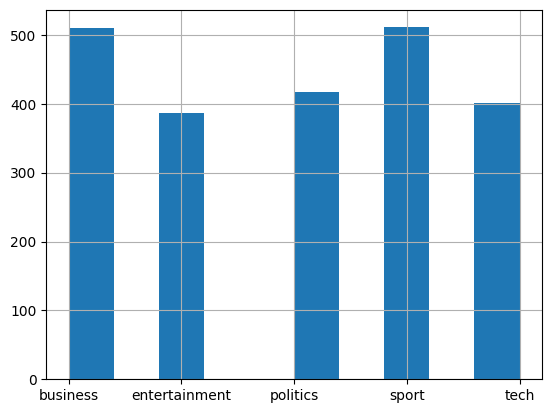

In [36]:
df['labels'].hist()

In [37]:
len(df)

2225

In [38]:
doc = df[df.labels == 'business']['text'].sample()
len(doc)

1

In [39]:
doc

162    US data sparks inflation worries\n\nWholesale ...
Name: text, dtype: object

In [44]:
def wrap(x):
  return textwrap.fill(x, replace_whitespace=False, fix_sentence_endings=True)

print(wrap(doc.iloc[0]))

US data sparks inflation worries

Wholesale prices in the US rose at
the fastest rate in more than six years in January, according to
government data.

New figures show the Labor Department producer price
index (PPI) rose by 0.3% - in line with forecasts.  But core producer
prices, which exclude food and energy costs, surged by 0.8%, the
biggest rise since December 1998, increasing inflationary concerns.
In contrast, the University of Michigan barometer of US retail
consumer confidence showed a slight dip.  The university's index of
consumer spending fell to 94.2 in early February from 95.5 in January,
which could indicate a fall in retail spending by the US public.  The
mixed set of data on Friday led to volatile early Wall Street trade,
as the Dow Jones, Standard and Poor's 500, and Nasdaq swung between
positive and negative territory.

The economic figures come on the
back of increased fears that the Federal Reserve chairman may be about
to raise interest rates in order to stifle an

In [45]:
summarizer = pipeline("summarization")

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [48]:
# removing the heading from the text
wrap(doc.iloc[0]).split('\n',1)[1]

'\nWholesale prices in the US rose at\nthe fastest rate in more than six years in January, according to\ngovernment data.\n\nNew figures show the Labor Department producer price\nindex (PPI) rose by 0.3% - in line with forecasts.  But core producer\nprices, which exclude food and energy costs, surged by 0.8%, the\nbiggest rise since December 1998, increasing inflationary concerns.\nIn contrast, the University of Michigan barometer of US retail\nconsumer confidence showed a slight dip.  The university\'s index of\nconsumer spending fell to 94.2 in early February from 95.5 in January,\nwhich could indicate a fall in retail spending by the US public.  The\nmixed set of data on Friday led to volatile early Wall Street trade,\nas the Dow Jones, Standard and Poor\'s 500, and Nasdaq swung between\npositive and negative territory.\n\nThe economic figures come on the\nback of increased fears that the Federal Reserve chairman may be about\nto raise interest rates in order to stifle any inflation

In [50]:
text_to_summarize = wrap(doc.iloc[0]).split('\n',1)[1]
summarizer(text_to_summarize)

[{'summary_text': ' Wholesale prices in the US rose at the fastest rate in more than six years in January . Core PPI core surged by 0.8%, the biggest rise since December 1998, increasing inflationary concerns . University of Michigan barometer of US retail confidence shows slight dip in consumer spending .'}]

In [53]:
wrap(summarizer(text_to_summarize)[0]['summary_text'])

' Wholesale prices in the US rose at the fastest rate in more than six\nyears in January . Core PPI core surged by 0.8%, the biggest rise\nsince December 1998, increasing inflationary concerns . University of\nMichigan barometer of US retail confidence shows slight dip in\nconsumer spending .'

## Text Translation

In [1]:
!wget -nc http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip


File ‘spa-eng.zip’ already there; not retrieving.



In [2]:
!unzip -nq spa-eng.zip

In [3]:
!ls

sample_data  spa-eng  spa-eng.zip


In [4]:
!ls spa-eng

_about.txt  spa.txt


In [5]:
!head spa-eng/spa.txt

Go.	Ve.
Go.	Vete.
Go.	Vaya.
Go.	Váyase.
Hi.	Hola.
Run!	¡Corre!
Run.	Corred.
Who?	¿Quién?
Fire!	¡Fuego!
Fire!	¡Incendio!


In [6]:
eng2spa = {}
for line in open('spa-eng/spa.txt'):
    line = line.rstrip()
    eng, spa = line.split('\t')
    if eng not in eng2spa:
        eng2spa[eng] = []
    eng2spa[eng].append(spa)



In [7]:
import random
key = random.sample(list(eng2spa.keys()),1)
val = eng2spa[key[0]]
print (key[0], ":", val)

How often have you been to Europe? : ['¿Cuántas veces has ido a Europa?']


In [8]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [9]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [10]:
tokenizer.tokenize('¿Qué me cuentas?'.lower())

['qué', 'me', 'cuentas']

In [11]:
tokens = tokenizer.tokenize('¿Qué me cuentas bella cio?'.lower())
sentence_bleu([tokens], tokens)

1.0

In [12]:
smoother = SmoothingFunction()
sentence_bleu([['hi']], ['hi'], smoothing_function=smoother.method1, weights=[0.9, 0.05, 0.05])

0.7943282347242815

In [13]:
eng2spa_tokens = {}
for eng, spa_list in eng2spa.items():
  spa_list_tokens = []
  for text in spa_list:
    tokens = tokenizer.tokenize(text.lower())
    spa_list_tokens.append(tokens)
  eng2spa_tokens[eng] = spa_list_tokens

In [14]:
import random
key = random.sample(list(eng2spa_tokens.keys()),1)
val = eng2spa_tokens[key[0]]
print (key[0], ":", val)

Freedom of speech was tightly restricted. : [['la', 'libertad', 'de', 'expresión', 'fue', 'firmemente', 'restringida']]


In [15]:
!pip install transformers sentencepiece transformers[sentencepiece]


In [16]:
# !pip install transformers[sentencepiece] datasets

In [17]:
from transformers import pipeline
translator = pipeline("translation",
                      model='Helsinki-NLP/opus-mt-en-es', device=0)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [18]:
translator("I like eggs and ham")

[{'translation_text': 'Me gustan los huevos y el jamón.'}]

In [19]:
eng_phrases = list(eng2spa.keys())
len(eng_phrases)

102904

In [20]:
eng_phrases_subset = eng_phrases[20_000:21_000]

In [22]:
eng_phrases_subset[:10]

['Tom is in the garden.',
 'Tom is in the shower.',
 'Tom is just like you.',
 'Tom is looking at us.',
 'Tom is my only child.',
 'Tom is never on time.',
 'Tom is not a student.',
 'Tom is not religious.',
 'Tom is now in prison.',
 'Tom is old-fashioned.']

In [21]:
translations = translator(eng_phrases_subset)

In [24]:
translations[:5]

[{'translation_text': 'Tom está en el jardín.'},
 {'translation_text': 'Tom está en la ducha.'},
 {'translation_text': 'Tom es como tú.'},
 {'translation_text': 'Tom nos está mirando.'},
 {'translation_text': 'Tom es mi único hijo.'}]

In [26]:
import numpy as np

In [28]:
scores = []
for eng, pred in zip(eng_phrases_subset, translations):
  matches = eng2spa_tokens[eng]

  # tokenize translation
  spa_pred = tokenizer.tokenize(pred['translation_text'].lower())

  score = sentence_bleu(matches, spa_pred, smoothing_function=smoother.method4)
  scores.append(score)

np.mean(scores)

0.5060863928355085

In [29]:
np.random.seed(1)

def print_random_translation():
  i = np.random.choice(len(eng_phrases_subset))
  eng = eng_phrases_subset[i]
  print("EN:", eng)

  translation = translations[i]['translation_text']
  print("ES Translation:", translation)

  matches = eng2spa[eng]
  print("Matches:", matches)

In [31]:
print_random_translation()

EN: Tom isn't that young.
ES Translation: Tom no es tan joven.
Matches: ['Tom no es tan joven.']


## QA

In [32]:
from transformers import pipeline
qa = pipeline("question-answering")

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [33]:
context = "Today I went to the store to purchase a carton of milk."
question = "What did I buy?"
qa(context=context, question=question)

{'score': 0.5626220107078552,
 'start': 38,
 'end': 54,
 'answer': 'a carton of milk'}

In [34]:
context[38:54]

'a carton of milk'

In [35]:
context = "Albert Einstein (14 March 1879 – 18 April 1955) was a " + \
  "German-born theoretical physicist, widely acknowledged to be one of the " + \
  "greatest physicists of all time. Einstein is best known for developing " + \
  "the theory of relativity, but he also made important contributions to " + \
  "the development of the theory of quantum mechanics. Relativity and " + \
  "quantum mechanics are together the two pillars of modern physics."

question = "When was Albert Einstein born?"
qa(context=context, question=question)

{'score': 0.951105535030365, 'start': 17, 'end': 30, 'answer': '14 March 1879'}

## Zero shot classification

In [36]:
!wget -nc https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv

--2024-01-08 10:53:01--  https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5085081 (4.8M) [text/csv]
Saving to: ‘bbc_text_cls.csv’

bbc_text_cls.csv    100%[===================>]   4.85M  16.5MB/s    in 0.3s    

2024-01-08 10:53:02 (16.5 MB/s) - ‘bbc_text_cls.csv’ saved [5085081/5085081]



In [37]:
from transformers import pipeline
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import textwrap
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

In [38]:
classifier = pipeline("zero-shot-classification", device=0)

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [39]:
classifier("This is a great movie", candidate_labels=["positive", "negative"])

{'sequence': 'This is a great movie',
 'labels': ['positive', 'negative'],
 'scores': [0.9969461560249329, 0.0030538279097527266]}

In [40]:
text = "Due to the presence of isoforms of its components, there are 12 " + \
  "versions of AMPK in mammals, each of which can have different tissue " + \
  "localizations, and different functions under different conditions. " + \
  "AMPK is regulated allosterically and by post-translational " + \
  "modification, which work together."
classifier(text, candidate_labels=["biology", "math", "geology"])

{'sequence': 'Due to the presence of isoforms of its components, there are 12 versions of AMPK in mammals, each of which can have different tissue localizations, and different functions under different conditions. AMPK is regulated allosterically and by post-translational modification, which work together.',
 'labels': ['biology', 'math', 'geology'],
 'scores': [0.8908600211143494, 0.06606590747833252, 0.04307400435209274]}

In [41]:
df = pd.read_csv('bbc_text_cls.csv')

In [44]:
len(df)

2225

In [42]:
df.sample(frac=1).head()

,text,labels
1526,Mansfield 0-1 Leyton Orient\n\nAn second-half ...,sport
891,Last Star Wars 'not for children'\n\nThe sixth...,entertainment
1617,Kirwan demands Italy consistency\n\nItaly coac...,sport
969,BNP leader Nick Griffin arrested\n\nThe leader...,politics
894,Hobbit picture 'four years away'\n\nLord of th...,entertainment


In [45]:
len(df.sample(frac=1))

2225

In [43]:
labels = list(set(df['labels']))
labels

['sport', 'politics', 'entertainment', 'business', 'tech']

In [46]:
print(textwrap.fill(df.iloc[1024]['text']))

UK troops on Ivory Coast standby  Downing Street has confirmed British
troops are on standby in case they need to help evacuate several
hundred UK citizens from Ivory Coast.  The news came as it emerged
France had begun evacuating its hostages after days of anti-French
demonstrations. Trouble flared after nine French peacekeepers were
killed and President Jacques Chirac ordered the destruction of the
Ivory Coast's air force. A company of 100-120 UK troops is understood
to have been put on standby. They are ready to fly out and secure the
route from the embassy to the airport if called upon. Prime Minister
Tony Blair's official spokesman said: "There are British nationals in
Ivory Coast and as you can imagine we are making the usual contingency
plans in case the situation deteriorates further, but that's all I can
say at this stage."  He added the situation would be monitored
carefully in case evacuation became necessary. France has played a
lead role in international peacekeeping in Iv

In [47]:
df.iloc[1024]['labels']

'politics'

In [48]:
classifier(df.iloc[1024]['text'], candidate_labels=labels)

{'sequence': 'UK troops on Ivory Coast standby\n\nDowning Street has confirmed British troops are on standby in case they need to help evacuate several hundred UK citizens from Ivory Coast.\n\nThe news came as it emerged France had begun evacuating its hostages after days of anti-French demonstrations. Trouble flared after nine French peacekeepers were killed and President Jacques Chirac ordered the destruction of the Ivory Coast\'s air force. A company of 100-120 UK troops is understood to have been put on standby. They are ready to fly out and secure the route from the embassy to the airport if called upon. Prime Minister Tony Blair\'s official spokesman said: "There are British nationals in Ivory Coast and as you can imagine we are making the usual contingency plans in case the situation deteriorates further, but that\'s all I can say at this stage."\n\nHe added the situation would be monitored carefully in case evacuation became necessary. France has played a lead role in internati

In [49]:
df.iloc[23]['text']

'US trade gap hits record in 2004\n\nThe gap between US exports and imports hit an all-time high of $671.7bn (£484bn) in 2004, latest figures show.\n\nThe Commerce Department said the trade deficit for all of last year was 24.4% above the previous record - 2003\'s imbalance of $496.5bn. The deficit with China, up 30.5% at $162bn, was the largest ever recorded with a single country. However, on a monthly basis the US trade gap narrowed by 4.9% in December to £56.4bn. The US consumer\'s appetite for all things from oil to imported cars, and even wine and cheese, reached record levels last year and the figures are likely to spark fresh criticism of President Bush\'s economic policies.\n\nDemocrats claim the administration has not done enough to clamp down on unfair foreign trade practices. For example, they believe China\'s currency policy - which US manufacturers claim has undervalued the yuan by as much as 40% - has given China\'s rapidly expanding economy an unfair advantage against US

In [50]:
df.iloc[23]['labels']

'business'

In [52]:
classifier(df.iloc[23]['text'], candidate_labels=labels)

{'sequence': 'US trade gap hits record in 2004\n\nThe gap between US exports and imports hit an all-time high of $671.7bn (£484bn) in 2004, latest figures show.\n\nThe Commerce Department said the trade deficit for all of last year was 24.4% above the previous record - 2003\'s imbalance of $496.5bn. The deficit with China, up 30.5% at $162bn, was the largest ever recorded with a single country. However, on a monthly basis the US trade gap narrowed by 4.9% in December to £56.4bn. The US consumer\'s appetite for all things from oil to imported cars, and even wine and cheese, reached record levels last year and the figures are likely to spark fresh criticism of President Bush\'s economic policies.\n\nDemocrats claim the administration has not done enough to clamp down on unfair foreign trade practices. For example, they believe China\'s currency policy - which US manufacturers claim has undervalued the yuan by as much as 40% - has given China\'s rapidly expanding economy an unfair advanta

In [53]:
preds = classifier(df['text'].tolist(), candidate_labels=labels)

In [54]:
predicted_labels = [d['labels'][0] for d in preds]
df['predicted_labels'] = predicted_labels
df['predicted_labels'] = predicted_labels


0.8853266860793887

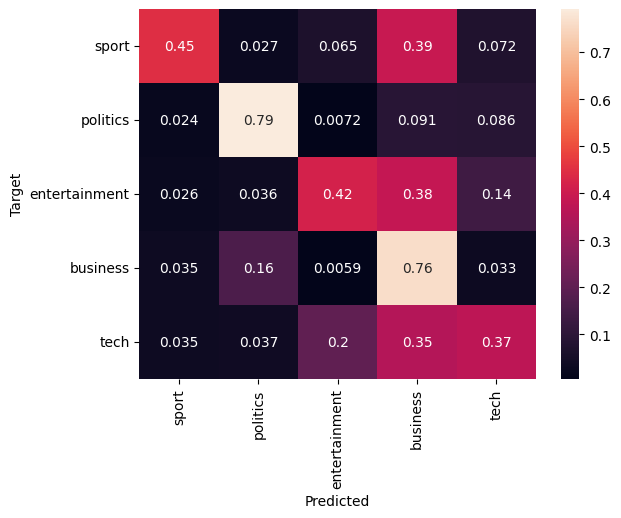

In [55]:
# Convert prediction probs into an NxK matrix according to
# original label order

N = len(df)
K = len(labels)
label2idx = {v:k for k,v in enumerate(labels)}

probs = np.zeros((N, K))
for i in range(N):
  # loop through labels and scores in corresponding order
  d = preds[i]
  for label, score in zip(d['labels'], d['scores']):
    k = label2idx[label]
    probs[i, k] = score

int_labels = [label2idx[x] for x in df['labels']]

int_preds = np.argmax(probs, axis=1)
cm = confusion_matrix(int_labels, int_preds, normalize='true')

def plot_cm(cm):
  df_cm = pd.DataFrame(cm, index=labels, columns=labels)
  ax = sn.heatmap(df_cm, annot=True, fmt='.2g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

plot_cm(cm)

roc_auc_score(int_labels, probs, multi_class='ovo')

In [8]:
import transformers
transformers.__version__

'4.32.1'